# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In progress</span></b></p>

##### LOAD IMAGE FILES

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

data_dir = '../../../data/'
classes = os.listdir(data_dir)  # get classes from folder names

# load feature data
filename = '../../02-data-preprocessing/output/preprocessed_data/X.pckl'
loader = open(filename, 'rb')
X = pickle.load(loader)
loader.close()

# load target data
filename = '../../02-data-preprocessing/output/preprocessed_data/y.pckl'
loader = open(filename, 'rb')
y = pickle.load(loader)
loader.close()

##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [2]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 64, 64, 3)
y_train : (240, 2)

X_test : (60, 64, 64, 3)
y_test : (60, 2)


##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [3]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model retraining
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### DEFINE NETWORK PARAMETERS

In [4]:
#extract images properties
image_width  = np.shape(X_test)[1]
image_height = np.shape(X_test)[2]
n_channel  = np.shape(X_test)[3]
n_classes = y_train.shape[1]
n_features = 3  # dummy

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features  # 11 neurons in input layer
n_layer_h1 = 50          # first   hidden layer
n_layer_h2 = 50          # second  hidden layer
n_layer_out = n_classes  # 7 neurons in input layer

sigma_init = 0.01   # For randomized initialization

##### MODEL ARCHITECTURE

In [5]:
# set up some parameters
keep_prob = 0.75
#keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

receptive_field = 3             # kernel filter = 3x3
feature_map = 32

# create symbolic variables
X = tf.placeholder(tf.float32, [None, image_width, image_height, n_channel])
Y = tf.placeholder(tf.float32, [None, n_classes])

# define some of the model's components
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

with tf.name_scope("cnn"):
    W_conv1 = weight_variable([receptive_field, receptive_field, n_channel, feature_map])  # [3,3,3,32]
    b_conv1 = bias_variable([feature_map])    # 32

    h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([receptive_field, receptive_field, feature_map, feature_map*2])  # [3,3,32,64]
    b_conv2 = bias_variable([feature_map*2])   # 64

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([int(image_width/4 * image_height/4 * (feature_map*2)), feature_map**2]) # [65536,1024]
    b_fc1 = bias_variable([feature_map**2])  # 1024

    h_pool2_flat = tf.reshape(h_pool2, [-1, int(image_width/4 * image_height/4 * (feature_map*2))])  # [~,16384]
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([feature_map**2, n_classes])
    b_fc2 = bias_variable([n_classes])

    y_pred = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

##### LEARNING RATE CONFIGURATION

In [6]:
learning_rate = 0.10

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.10
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### OPTIMIZER AND ACCURACY CONFIGURATION

In [7]:
with tf.name_scope("loss"):
    #loss = tf.square(Y - y_pred)                                                       # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    #optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    

# Create summaries
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar("learn_rate", learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### DEFINE DIRECTORIES FOR RESULTS

In [8]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))

##### MODEL EXECUTION

In [9]:
# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# define some parameters
n_epochs = 150
display_epoch = 10
batch_size = 10
n_batches = int(n_train/batch_size)

# this will later help me to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
avg_loss_list = []
learning_list = []


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in tqdm(range(1, n_epochs+1)):
        avg_loss = 0    # accumulate batch average loss for each epoch
        
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # start model training
            sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
            # Run optimization (backprop), cost and summary nodes
            _, _loss, _summary = sess.run([training_op, loss, merged_summary_op],
                                          feed_dict={X:X_batch, Y:y_batch})
            avg_loss += _loss/n_batches
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary)
            
        # after the epoch is finished this will append the loss
        avg_loss_list.append(avg_loss)
            
        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _acc_train = accuracy.eval(feed_dict={X: X_train, Y:y_train})
            _acc_test = accuracy.eval(feed_dict={X: X_test, Y: y_test})
            
            # append results to lists
            acc_train_list.append(_acc_train); acc_test_list.append(_acc_test)
            learning_list.append(sess.run(learning_rate))

            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, "{}/epoch{:04}.ckpt".format(root_ckpoint, (epoch+1)))
            
            print("Epoch: {:04}\tTrainAcc: {:06.5f}\tTestAcc: {:06.5f}\tLoss: {:06.5f}\tLearning: {:06.7f}".format((epoch+1),
                                                                                                                   _acc_train,
                                                                                                                   _acc_test,
                                                                                                                   avg_loss,
                                                                                                                   sess.run(learning_rate)))

Epoch: 0010	TrainAcc: 0.49583	TestAcc: 0.46667	Loss: 0.69364	Learning: 0.1000000
Epoch: 0020	TrainAcc: 0.49583	TestAcc: 0.46667	Loss: 0.69303	Learning: 0.1000000
Epoch: 0030	TrainAcc: 0.49583	TestAcc: 0.46667	Loss: 0.69328	Learning: 0.1000000
Epoch: 0040	TrainAcc: 0.49583	TestAcc: 0.48333	Loss: 0.69291	Learning: 0.1000000
Epoch: 0050	TrainAcc: 0.49167	TestAcc: 0.46667	Loss: 0.69293	Learning: 0.1000000
Epoch: 0060	TrainAcc: 0.50833	TestAcc: 0.45000	Loss: 0.69328	Learning: 0.1000000
Epoch: 0070	TrainAcc: 0.49167	TestAcc: 0.46667	Loss: 0.69313	Learning: 0.1000000
Epoch: 0080	TrainAcc: 0.47917	TestAcc: 0.45000	Loss: 0.69329	Learning: 0.1000000
Epoch: 0090	TrainAcc: 0.50000	TestAcc: 0.46667	Loss: 0.69300	Learning: 0.1000000
Epoch: 0100	TrainAcc: 0.48333	TestAcc: 0.45000	Loss: 0.69298	Learning: 0.1000000
Epoch: 0110	TrainAcc: 0.48750	TestAcc: 0.43333	Loss: 0.69347	Learning: 0.1000000
Epoch: 0120	TrainAcc: 0.51667	TestAcc: 0.48333	Loss: 0.69291	Learning: 0.1000000
Epoch: 0130	TrainAcc: 0.4583

##### VISUALIZE THE RESULTS

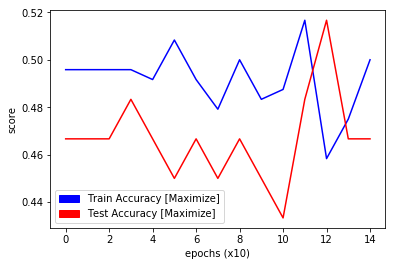

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(acc_train_list, color='blue')
plt.plot(acc_test_list, color='red')

plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('score');

##### LEARNING RATE EVOLUTION

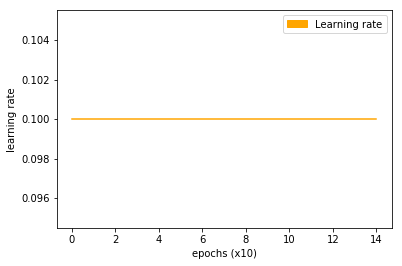

In [12]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(learning_list, color='orange');
plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('learning rate');